In [1]:
import json
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from model_config import RemoteModel  # noqa: E402
from settings import refresh_settings  # noqa: E402

settings = refresh_settings()

/Users/mac/Desktop/Projects/smart-rag


# Adaptive RAG

Adaptive RAG is an advanced retrieval-augmented generation (RAG) architecture that intelligently combines **traditional RAG techniques** with **self-reflection** and **external tool usage** to enhance the quality and reliability of generated answers.

<br>

[![image.png](https://i.postimg.cc/65nZVgN9/image.png)](https://postimg.cc/ZCY04fRg)

[Source: LangChain](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

<br>

### Breakdown of the above diagram

#### 1.) Query Analysis (Red Box)

- The user's Question first goes to a Query Analysis step (likely an LLM prompt or classifier).
- It determines if the question is [related to index] (the internal knowledge base) or [unrelated to index] (requiring external tools).

#### 2.) RAG + Self-Reflection (Top Dashed Box)

- If related to the index, the query proceeds through the RAG workflow.
- Retrieve & Grade: The system fetches documents (Retrieve Node), and then an LLM agent grades their relevance.
- Decision Loop:
  - If the documents are relevant, it proceeds to Generate (Node) and then checks for Hallucinations?
  - If the answer is free of hallucinations and Answers question? successfully, the process stops with the final Answer.
  - If the documents are not relevant or the generated answer fails the self-reflection checks, the question is sent to the Re-write question (Node) and the process loops back to Retrieve. This allows the agent to iteratively improve its search query.

#### 3.) Tool Use (Bottom Green Path)

- If the original Query Analysis determined the question was [unrelated to index], it activates the Web search tool, generates the answer using the web results, and provides the Answer w/ web search.

In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


### Load documents


In [5]:
from glob import glob

from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents.base import Document


def load_pdf_doc(filepath: str, engine: str = "pypdfloader") -> list[Document]:
    """This is used to load a single document."""
    if engine == "pypdfloader":
        loader = PyPDFLoader(filepath)
    docs: list[Document] = loader.load()
    return docs


# Load a single doc
fp: str = "../data/ai_news/Inside_San_Francisco’s_AI_school.pdf"
docs = load_pdf_doc(filepath=fp)
docs

[Document(metadata={'producer': 'Skia/PDF m141', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36', 'creationdate': '2025-10-23T18:16:12+00:00', 'title': 'Inside San Francisco’s new AI school: is this the future of US education? | Artificial intelligence (AI) | The Guardian', 'moddate': '2025-10-23T18:16:12+00:00', 'source': '../data/ai_news/Inside_San_Francisco’s_AI_school.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1'}, page_content='Artiﬁcial intelligence (AI)\nInside San Francisco’s new AI school: is this the future of US education?\nThe private Alpha School says its students can learn faster and better –but experts warn not all may beneﬁt from an AI boom in schools\nRobin Buller\nSat 18 Oct 2025 14.00 BST\nIn the world’s tech innovation epicenter, an “AI-powered” private school has made headlines for unabashedly embracing thetechnology.\nAlpha School San Francisco, which opened its doors to K-8 

In [6]:
# Load multiple docs
ai_filepaths: list[str] = glob("../data/ai_news/*.pdf")
docs_ai = [doc for fp in ai_filepaths for doc in load_pdf_doc(filepath=fp)]
print(len(docs_ai))

football_filepaths: list[str] = glob("../data/football/*.pdf")
docs_football = [doc for fp in football_filepaths for doc in load_pdf_doc(filepath=fp)]
print(len(docs_football))

43
174


In [7]:
docs_ai[:5]

[Document(metadata={'producer': 'Skia/PDF m141', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36', 'creationdate': '2025-10-23T18:26:47+00:00', 'title': 'Nvidia to invest $100bn in OpenAI, firm behind ChatGPT', 'moddate': '2025-10-23T18:26:47+00:00', 'source': '../data/ai_news/nvidia.pdf', 'total_pages': 3, 'page': 0, 'page_label': '1'}, page_content='Nvidia to invest $100bn in OpenAI\n22 September 2025 Save\nFaarea Masud\nBusiness reporter\nShare\nGetty Images\nUS tech giant Nvidia will invest up to $100bn (£73bn) in OpenAI, the firm behind\nChatGPT, the companies have announced.\nNvidia said it will supply high-performance chips needed for the processing power\nrequired by artificial intelligence (AI), of which OpenAI is a specialist.\nDescribed as a "strategic partnership" by Nvidia, it is the latest move by two high\nprofile tech firms in the global AI race, where China is an emerging rival.\nThe anno

In [8]:
console.print(docs_ai[0])

Document(
    metadata={
        'producer': 'Skia/PDF m141',
        'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) 
Chrome/141.0.0.0 Safari/537.36',
        'creationdate': '2025-10-23T18:26:47+00:00',
        'title': 'Nvidia to invest $100bn in OpenAI, firm behind ChatGPT',
        'moddate': '2025-10-23T18:26:47+00:00',
        'source': '../data/ai_news/nvidia.pdf',
        'total_pages': 3,
        'page': 0,
        'page_label': '1'
    },
    page_content='Nvidia to invest $100bn in OpenAI\n22 September 2025 Save\nFaarea Masud\nBusiness 
reporter\nShare\nGetty Images\nUS tech giant Nvidia will invest up to $100bn (£73bn) in OpenAI, the firm 
behind\nChatGPT, the companies have announced.\nNvidia said it will supply high-performance chips needed for the 
processing power\nrequired by artificial intelligence (AI), of which OpenAI is a specialist.\nDescribed as a 
"strategic partnership" by Nvidia, it is the latest move by two high\nprofile tech firms in the global AI race, 
where China is an emerging rival.\nThe announcement comes after a series of high-profile investments by 
Nvidia,\nincluding a $5bn investment in Intel and a £2bn investment in the UK\'s AI sector.\nNvidia, which is the 
world\'s most valuable company, said its latest investment will go\ntowards data centres for OpenAI\'s 
"next-generation AI infrastructure".\nJensen Huang, chief executive of Nvidia, said the funding will mark the "next
leap\nforward and power the next era of intelligence".\nBoth firms said they were already working with a broad 
network of collaborators\nfocused on making the "world\'s most advanced AI infrastructure", including working\nwith
Microsoft, Oracle, SoftBank, and Stargate.\nHowever, the dominance of US AI firms has come under threat from China 
-\nparticularly with the rise of DeepSeek-R1.\nHome News Sport Business Innovation Culture Arts Travel Earth Audio 
Video Live\nYour Account\n10/23/25, 7:26 PM Nvidia to invest $100bn in OpenAI, ﬁrm behind 
ChatGPT\nhttps://www.bbc.com/news/articles/c0knp3557j2o 1/3'
)

### Set up document embeddings

In [9]:
import os
from typing import Any, List

import together
from langchain_core.embeddings import Embeddings
from langchain_core.utils import convert_to_secret_str
from pydantic import (
    BaseModel,
    ConfigDict,
    Field,
    SecretStr,
    model_validator,
)


def set_together_api(value: str | None = None) -> SecretStr:
    """Set the Together API key"""
    if value is None:
        return convert_to_secret_str(os.getenv("TOGETHER_API_KEY", ""))
    return convert_to_secret_str(value)


class TogetherEmbeddings(BaseModel, Embeddings):
    """Using Field with default_factory for automatic client creation."""

    model_config = ConfigDict(arbitrary_types_allowed=True)

    client: together.Together = Field(default_factory=together.Together)
    together_api_key: SecretStr = Field(default_factory=lambda: set_together_api)
    model: str = Field(default="togethercomputer/m2-bert-80M-32k-retrieval")

    @model_validator(mode="before")
    @classmethod
    def validate_environment(cls, values: dict[str, Any]) -> dict[str, Any]:
        """Set up the Together API key and client before model instantiation."""
        # Handle API key setup
        api_key = values.get("together_api_key") or os.getenv("TOGETHER_API_KEY", "")
        if isinstance(api_key, str):
            api_key = set_together_api(api_key)
        values["together_api_key"] = api_key
        values["client"] = together.Together()

        # Set global API key
        together.api_key = api_key.get_secret_value()

        return values

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed search docs."""
        return [i.embedding for i in self.client.embeddings.create(input=texts, model=self.model).data]  # type: ignore

    def embed_query(self, text: str) -> List[float]:
        """Embed query text."""
        return self.embed_documents([text])[0]

In [10]:
# Test with a known working Together AI model
embeddings = TogetherEmbeddings(
    model="BAAI/bge-base-en-v1.5",  # Using known working model
    together_api_key=settings.TOGETHER_API_KEY.get_secret_value(),
)

# Test the embedding
try:
    test_text = "This is a test embedding"
    result = embeddings.embed_query(test_text)
    console.print(f"✅ Embedding successful! Dimension: {len(result)}", style="success")
    console.print(f"First 5 values: {result[:5]}", style="info")

except Exception as e:
    console.print(f"❌ Embedding failed: {e}", style="error")

✅ Embedding successful! Dimension: 768

First 5 values: [0.01778671145439148, -0.045254334807395935, 0.02533785067498684, 0.033748067915439606, 
0.05268585681915283]

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

client = QdrantClient(":memory:")

vector_size = len(embeddings.embed_query("sample text"))
collection_name_ai = "ai_news"

if not client.collection_exists(collection_name_ai):
    client.create_collection(
        collection_name=collection_name_ai,
        vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
    )
vectorstore_ai = QdrantVectorStore(
    client=client,
    collection_name=collection_name_ai,
    embedding=embeddings,
)


collection_name_football = "football_news"

if not client.collection_exists(collection_name_football):
    client.create_collection(
        collection_name=collection_name_football,
        vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
    )
vectorstore_football = QdrantVectorStore(
    client=client,
    collection_name=collection_name_football,
    embedding=embeddings,
)

### Split Documents Into Chunks

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter_ai = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters)
    chunk_overlap=50,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits_ai = text_splitter_ai.split_documents(docs_ai)

print(f"Split into {len(all_splits_ai)} sub-documents.")


text_splitter_football = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters)
    chunk_overlap=50,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits_football = text_splitter_football.split_documents(docs_football)

print(f"Split into {len(all_splits_football)} sub-documents.")

Split into 168 sub-documents.
Split into 567 sub-documents.


### Embed The Document Chunks And Add to Vector Store

In [ ]:
document_ids: list[str] = vectorstore_ai.add_documents(documents=all_splits_ai)
print(document_ids[:3])

document_ids: list[str] = vectorstore_football.add_documents(documents=all_splits_football)

['a599f850484546238ddba207484aa095', 'fbc3ec541d184ad988c3ffbc3412f0e2', '90c4a8df99e84725989533eef164e264']


<br>

### Alternative Method

- Fewer lines of code

In [14]:
RUN: bool = False

if RUN:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,  # chunk size (characters)
        chunk_overlap=100,  # chunk overlap (characters)
        add_start_index=True,  # track index in original document
    )

    all_splits = text_splitter.split_documents(docs)

    vector_store = QdrantVectorStore.from_documents(
        documents=all_splits,
        embedding=embeddings,
        location=":memory:",  # for in-memory Qdrant instance
        # OR specify url and api_key for external Qdrant instance
        # url="http://localhost:6333",  # assuming local Qdrant server is running
        # api_key="your_qdrant_api_key",  # if needed (for cloud instances)
        collection_name="test",
    )

### Test Retrieval from Vector Store

In [ ]:
query: str = "Has Nvidia broken any laws?"

retrieved_docs = vectorstore_ai.similarity_search(query, k=2)
formatted_docs: str = "\n\n".join((f"Source: {doc.metadata}\nContent: {doc.page_content}") for doc in retrieved_docs)

console.print(formatted_docs)

Source: {'producer': 'Skia/PDF m141', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) 
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36', 'creationdate': 
'2025-10-23T18:26:47+00:00', 'title': 'Nvidia to invest $100bn in OpenAI, firm behind ChatGPT', 'moddate': 
'2025-10-23T18:26:47+00:00', 'source': '../data/ai_news/nvidia.pdf', 'total_pages': 3, 'page': 1, 'page_label': 
'2', 'start_index': 0, '_id': '35e1d1fbb2ec40aaac8359800a44cd08', '_collection_name': 'ai_news'}
Content: Meanwhile, Nvidia has come under pressure from both the Chinese and the US
governments.
China said last week Nvidia had violated its anti-monopoly laws, but did not give
details of how Nvidia had breached the rules.
China also reportedly ordered its top technology companies to halt purchases of the
firm's artificial intelligence (AI) chips. Huang told the BBC at the time he was
"disappointed" with the news.
It came after Nvidia and its rival AMD agreed to pay the US government 15% of

Source: {'producer': 'Skia/PDF m141', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) 
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36', 'creationdate': 
'2025-10-23T18:26:47+00:00', 'title': 'Nvidia to invest $100bn in OpenAI, firm behind ChatGPT', 'moddate': 
'2025-10-23T18:26:47+00:00', 'source': '../data/ai_news/nvidia.pdf', 'total_pages': 3, 'page': 1, 'page_label': 
'2', 'start_index': 1399, '_id': '8188cfd798384004aba0ea4e6b06971a', '_collection_name': 'ai_news'}
Content: working closely with Nvidia since "the early days" of the business.
Artiﬁcial intelligence Nvidia
RELATED
Amazon unveils prototype AIsmart glasses for its deliverydrivers
'Disgraceful' deep-fake AI videocondemned by presidentialcandidate
Author Philip Pullman calls ongovernment to act over 'wicked'AI scraping
MORE FROM THE BBC
6 Oct 2025 How China is challenging Nvidia's AI chipdominance
Beijing has urged local ﬁrms to use homemade chips. But is China ready toturn away from Nvidia?
6 Oct 2025

### Convert Retriever To A Tool

- I eventually did NOT use this approach in the final implementation, but it's good to know how to do it.
- This is because when the agent uses the tool, it returns the output as a string, which makes it difficult to pass the retrieved documents to the LLM call node for further processing.


In [ ]:
from langchain.tools import tool
from langchain_core.documents.base import Document


@tool(response_format="content_and_artifact")
def retriever_ai_tool(query: str) -> tuple[str, list[Document]]:
    """Retrieve information related to AI news to help answer a query.
    AI news include ANY info relating to: nvidia, openai, google, chinese tech news, etc.

    Parameters:
    -----------
    query: str
        The search query to retrieve relevant documents.

    Returns:
    --------
    tuple[str, list[Document]]
        A tuple containing formatted string of retrieved documents and the list of Document objects.
    """
    retrieved_docs = vectorstore_ai.similarity_search(query, k=2)
    formatted_docs: str = "\n\n".join((f"Source: {doc.metadata}\nContent: {doc.page_content}") for doc in retrieved_docs)
    return formatted_docs, retrieved_docs


@tool(response_format="content_and_artifact")
def retriever_football_tool(query: str) -> tuple[str, list[Document]]:
    """Retrieve information related to football news to help answer a query.

    Parameters:
    -----------
    query: str
        The search query to retrieve relevant documents.

    Returns:
    --------
    tuple[str, list[Document]]
        A tuple containing formatted string of retrieved documents and the list of Document objects.
    """
    retrieved_docs = vectorstore_football.similarity_search(query, k=2)
    formatted_docs: str = "\n\n".join((f"Source: {doc.metadata}\nContent: {doc.page_content}") for doc in retrieved_docs)
    return formatted_docs, retrieved_docs

In [22]:
llm_with_tools = remote_llm.bind_tools([retriever_ai_tool, retriever_football_tool])
response = await llm_with_tools.ainvoke("Has Nvidia broken any laws?")

response.tool_calls

[{'name': 'retriever_ai_tool',
  'args': {'query': 'Has Nvidia broken any laws?'},
  'id': 'tool_0_retriever_ai_tool_Z4qTZRiDQ4XLidfOOI9Z',
  'type': 'tool_call'}]

In [23]:
response

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 185, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761404017-kqjGfTstuMsnDF3kWmdo', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--e5275206-0071-4a9a-bf0c-8247abe6c2b1-0', tool_calls=[{'name': 'retriever_ai_tool', 'args': {'query': 'Has Nvidia broken any laws?'}, 'id': 'tool_0_retriever_ai_tool_Z4qTZRiDQ4XLidfOOI9Z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185, 'output_tokens': 13, 'total_tokens': 198, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

#### Create Additional Tools

In [24]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)
search_response = tavily_search.invoke({"query": "Has Nvidia broken any laws?"})

In [25]:
search_response["results"][0]["content"]

"China's market regulator said a preliminary investigation found U.S. chip maker Nvidia had violated antimonopoly laws."

In [26]:
search_response

{'query': 'Has Nvidia broken any laws?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.barrons.com/articles/nvidia-stock-china-monopoly-laws-36c1517c?gaa_at=eafs&gaa_n=AWEtsqf3-JF4kFjSJbQIsY9mQem2XzaEXvTmg4H48Y_xpTtV0aE6Nq1l7NN9&gaa_ts=68fce80b&gaa_sig=3zRE3JX_Pg4CdAyHgOswElg2VYKZ5yzhMPpBUXR-yXIFaw6m6VkJ3b8Wp3kukvqzYqO99l6wj5LHoWV1czsFHA%3D%3D',
   'title': 'China Says Nvidia Broke Monopoly Laws. What It Means ...',
   'content': "China's market regulator said a preliminary investigation found U.S. chip maker Nvidia had violated antimonopoly laws.",
   'score': 0.85097736,
   'raw_content': None},
  {'url': 'https://www.nytimes.com/2025/09/15/technology/nvidia-china-antitrust.html',
   'title': 'Nvidia Broke Antitrust Law, China Says, as Tensions With ...',
   'content': "China's antimonopoly regulator said on Monday that Nvidia, America's leading chip maker, had violated the country's antitrust law, the latest",
   'score': 0.8409005,


In [27]:
@tool(response_format="content")
async def search_tool(query: str, max_chars: int = 500) -> str:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=1000
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results

In [28]:
console.print(search_tool)

StructuredTool(
    name='search_tool',
    description='Perform a search using TavilySearch tool.\n\n    Parameters:\n    -----------\n    query: str\n   
The search query.\n    max_chars: int, default=1000\n        The maximum number of characters per source to return 
from the search results.\n\n    Returns:\n    --------\n    str\n        The formatted search results.',
    args_schema=<class 'langchain_core.utils.pydantic.search_tool'>,
    coroutine=<function search_tool at 0x115c47d80>
)

In [29]:
response = await search_tool.coroutine("who is pope leo?")
console.print(response)

Title: Pope Leo XIV
Content: Pope Leo XIV is the head of the Catholic Church and sovereign of the Vatican City State. He is the first 
pope to have been born in the United States, 
URL: https://en.wikipedia.org/wiki/Pope_Leo_XIV



Title: Leo XIV | Pope, Background, Family, Name, Nationality ...
Content: Leo XIV is the pope, the leader of the Roman Catholic Church. Born Robert Francis Prevost in Chicago in 
1955, he was elected to the papacy on May 8, 2025, becoming the first American pope in history. Before becoming 
pope in 2025, Leo XIV was an Augustinian priest who did extensive missionary work in Peru and served as prior and 
director of missions and vocations of the Augustinian province in Chicago. **Leo XIV** (born September 14, 1955, 
Chicago, Illinois, U.S.) is the pope, the leader of the R 
URL: https://www.britannica.com/biography/Leo-XIV



Title: villanova celebrates pope leo xiv
Content: # VILLANOVA CELEBRATES POPE LEO XIV A Villanova University alumnus, Pope Leo XIV is the first Pope from 
the United States and the first Augustinian friar to be elected pontiff. Today, in St. Peter’s Square in front of 
Catholics from around the world, Cardinal Robert Prevost, now known as His Holiness Pope Leo XIV, was named the 
first Augustinian Pope. With today’s election of His Holiness, Pope Leo XIV, I cannot help but reflect on what his 
Augustinian papacy will mean to our University communit 
URL: https://www1.villanova.edu/university/pope-leo-xiv.html

In [30]:
search_response = await search_tool.coroutine("Has Nvidia broken any laws?")
console.print(search_response)

Title: China Says Nvidia Broke Monopoly Laws. What It Means ...
Content: China's market regulator said a preliminary investigation found U.S. chip maker Nvidia had violated 
antimonopoly laws. 
URL: 
https://www.barrons.com/articles/nvidia-stock-china-monopoly-laws-36c1517c?gaa_at=eafs&gaa_n=AWEtsqc-TXOqTN4rZ0NCUs
qhDsxrdDD5l-b50uDCUOY3uDRhISGUzyJ1i-iz&gaa_ts=68fce84e&gaa_sig=vSWeEzJTVhcJVwDsB4a-G-Vs8K7InF32JSDmRrjGXc3jiF5Y2NJD
r2HG0PUbFJ6vgHexJn3roIxC6Xa6R7b3FQ%3D%3D



Title: Nvidia Broke Antitrust Law, China Says, as Tensions With ...
Content: China's antimonopoly regulator said on Monday that Nvidia, America's leading chip maker, had violated the 
country's antitrust law, the latest 
URL: https://www.nytimes.com/2025/09/15/technology/nvidia-china-antitrust.html



Title: China: Nvidia violated anti-monopoly law, will continue ...
Content: * China's market regulator on Monday said that Nvidia violated the country's anti-monopoly law in relation
to its aquisition of Mellanox in 2020. China's market regulator on Monday said that Nvidia violated the country's 
anti-monopoly law, according to a preliminary probe, adding that Beijing would continue its investigation into the 
U.S. chip giant. In a preliminary investigation, the SAMR said Nvidia had violated China's anti-monopoly laws in 
relation to that acquisition and its conditions. Ch 
URL: https://www.cnbc.com/2025/09/15/china-nvidia-violated-anti-monopoly-law-will-continue-investigation.html

In [ ]:
from enum import Enum

from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
)


# ==================================================================
# ============================= TYPES ==============================
# ==================================================================
class YesOrNo(str, Enum):
    YES = "yes"
    NO = "no"


class DataSource(str, Enum):
    VECTORSTORE = "vectorstore"
    WEBSEARCH = "websearch"


class VectorSearchType(str, Enum):
    FOOTBALL = "football news"  # "(arsenal news | chelsea news | liverpool news)"
    AI = "ai news"  # "(ai news | ai browser | nvidia | openai| tech in china)"


# ==================================================================
# ============================ SCHEMAS =============================
# ==================================================================
class RouteQuerySchema(BaseModel):
    """Route query model."""

    data_source: DataSource = Field(description="The data source to use for the query.")


class VectorSearchTypeSchema(BaseModel):
    """Vector search type model."""

    vector_search_type: VectorSearchType = Field(description="The vector search type to use for the query.")


class GradeRetrievalSchema(BaseModel):
    """Grade retrieval model."""

    is_relevant: YesOrNo = Field(description="Whether the retrieved documents are relevant to the user query.")


class GradeResponseSchema(BaseModel):
    """Grade response model."""

    is_relevant: YesOrNo = Field(description="Whether the response is relevant to the user query.")


class HallucinationSchema(BaseModel):
    """Check hallucination model."""

    is_hallucinating: YesOrNo = Field(description="Whether the response contains hallucinations.")


topics: list[str] = [_topic.value for _topic in VectorSearchType]
valid_output: list[str] = [_typ.value for _typ in YesOrNo]

In [32]:
# ==================================================================
# ============================ PROMPTS =============================
# ==================================================================
query_analysis_prompt: str = """
<SYSTEM>
    <ROLE>
        You're an expert at determining whether a user query requires information from a vector store or a web search.
    </ROLE>
    <TOPICS>{topics}</TOPICS>

    <GUIDELINES>
    - If the query is related to the topics above, choose 'vectorstore'.
    - If the query is not covered by the topics above, choose 'websearch'.
    - Base your decision solely on the content of the query.
    </GUIDELINES>
</SYSTEM> 
"""

retrieval_grading_prompt: str = """
<SYSTEM>
    <ROLE>
        You're an expert at determining whether the retrieved documents from a vector store is relevant to the user query.
    </ROLE>
    <VALID_OUTPUT>{valid_output}</VALID_OUTPUT>

    <GUIDELINES>
    - If the documents are relevant to the user query, choose 'yes'.
    - If the documents are not relevant to the user query, choose 'no'.
    </GUIDELINES>

</SYSTEM> 
"""

query_n_retrieved_docs_prompt: str = """
<QUERY>{query}</QUERY>
<RETRIEVED_DOCUMENTS>{retrieved_documents}</RETRIEVED_DOCUMENTS>

Are the retrieved documents relevant to the user query?
"""

query_n_response_prompt: str = """
<QUERY>{query}</QUERY>
<RESPONSE>{response}</RESPONSE>

Is the response relevant to the user query?
"""

rag_response_generator_prompt: str = """
<ROLE>
    You're an expert at generating accurate and concise answers to user queries based on retrieved documents.
</ROLE>

    <QUERY>{query}</QUERY>
    <RETRIEVED_DOCUMENTS>{retrieved_documents}</RETRIEVED_DOCUMENTS>

    <GUIDELINES>
    - Limit your summary to a maximum of 5 sentences.
    - Use only the information provided in the retrieved documents.
    </GUIDELINES>
"""

hallucination_prompt: str = """
<SYSTEM>
    <ROLE>
        You're an expert at determining whether the generated response is accurate and relevant to the user query.
    </ROLE>
    <VALID_OUTPUT>{valid_output}</VALID_OUTPUT>

    <GUIDELINES>
    - If the response is NOT relevant to the user query, choose 'yes'.
    - If the response is relevant to the user query, choose 'no'.
    </GUIDELINES>

</SYSTEM> 
"""

query_rewriter_prompt: str = """
<ROLE>
    You're an expert at rewriting user queries to improve vector search retrieval.
</ROLE>

<ORIGINAL_QUERY>{original_query}</ORIGINAL_QUERY>

<GUIDELINES>
- Rewrite the query to be more specific and clear.
- Ensure the rewritten query captures the user's intent accurately.
- There must be no preamble, just the single rewritten query.
</GUIDELINES>
"""

websearch_prompt: str = """
<SYSTEM>
    <ROLE>
        You are an expert assistant specialized in generating a concise summary of web search results.
    </ROLE>

    <GUIDELINES>
    - Summarize the search results accurately and concisely.
    - Limit your summary to a maximum of 5 sentences.
    </GUIDELINES>

</SYSTEM>
"""

vectorstore_routing_prompt = """
<INSTR>
    Analyze this query and determine which retriever to use.
    <QUERY>{query}</QUERY>
</INSTR>
    """

In [33]:
topics

['football news', 'ai news']

In [ ]:
# ==================================================================
# ============================= TOOLS ==============================
# ==================================================================
@tool(response_format="content")
async def search_tool(query: str, max_chars: int = 500) -> str:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=500
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results


tool_names = ["retriever_ai_tool", "retriever_football_tool"]
tool_names

['retriever_ai_tool', 'retriever_football_tool']

<br>

### Define Workflow

In [ ]:
# vectorstore_football.as_retriever(search_kwargs={"k": 5}).invoke("Any news about Caicedo's contract situation?")

### Structured Output

- For structured output, I decided to use `Instructor` because it performs better than Langchain's built-in Pydantic output parser in my tests.

In [56]:
import instructor
from langchain_core.messages import AIMessage
from langsmith import traceable
from openai import AsyncOpenAI

_async_client = AsyncOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
    base_url=settings.OPENROUTER_URL,
)

aclient = instructor.from_openai(
    _async_client, mode=instructor.Mode.OPENROUTER_STRUCTURED_OUTPUTS
)

type PydanticModel = type[BaseModel]


@traceable
async def get_structured_output(
    messages: list[dict[str, Any]],
    model: RemoteModel,
    schema: PydanticModel,
) -> BaseModel:
    """
    Retrieves structured output from a chat completion model.

    Parameters
    ----------
    messages : list[dict[str, Any]]
        The list of messages to send to the model for the chat completion.
    model : RemoteModel
        The remote model to use for the chat completion (e.g., 'gpt-4o').
    schema : PydanticModel
        The Pydantic schema to enforce for the structured output.

    Returns
    -------
    BaseModel
        An instance of the provided Pydantic schema containing the structured output.

    Notes
    -----
    This is an asynchronous function that awaits the completion of the API call.
    """
    return await aclient.chat.completions.create(
        model=model,
        response_model=schema,
        messages=messages,
        max_retries=5,
    )


def convert_langchain_messages_to_dicts(
    messages: list[HumanMessage | SystemMessage | AIMessage],
) -> list[dict[str, str]]:
    """Convert LangChain messages to a list of dictionaries.

    Parameters
    ----------
    messages : list[HumanMessage | SystemMessage | AIMessage]
        List of LangChain message objects to convert.

    Returns
    -------
    list[dict[str, str]]
        List of dictionaries with 'role' and 'content' keys.
        Roles are mapped as follows:
        - HumanMessage -> "user"
        - SystemMessage -> "system"
        - AIMessage -> "assistant"

    """
    role_mapping: dict[str, str] = {
        "SystemMessage": "system",
        "HumanMessage": "user",
        "AIMessage": "assistant",
    }

    converted_messages: list[dict[str, str]] = []
    for msg in messages:
        message_type: str = msg.__class__.__name__
        role: str = role_mapping.get(
            message_type, "user"
        )  # Default to "user" if unknown
        converted_messages.append({"role": role, "content": msg.content})

    return converted_messages

In [36]:
class Person(BaseModel):
    fullname: str
    salary: float
    exeprience: int


await get_structured_output(
    messages=[
        {
            "role": "user",
            "content": "Neidu Emmanuel, earning 30,000 has 4 years of experience",
        }
    ],
    model=RemoteModel.LLAMA_3_3_70B_INSTRUCT,
    schema=Person,
)

Person(fullname='Neidu Emmanuel', salary=30000.0, exeprience=4)

In [57]:
import operator as op
from typing import Annotated, TypedDict


# ==================================================================
# ================== CUSTOM REDUCER FOR DICT =======================
# ==================================================================
def merge_dicts(existing: dict[str, Any], new: dict[str, Any]) -> dict[str, Any]:
    """Merge two dictionaries, with new values updating existing ones."""
    if existing is None:
        return new
    # Update existing dict with new dict values
    return {**existing, **new}


# ==================================================================
# ============================= STATE ==============================
# ==================================================================
class OtherInfo(TypedDict):
    source_type: str
    retrieval_relevance: str
    is_hallucinating: str
    rewritten_query: str


class State(TypedDict):
    query: str
    messages: Annotated[list[str], op.add]
    runs: int
    other_info: Annotated[dict[str, Any], merge_dicts]  # Use custom merger
    documents: list[Document]
    response: str


# ==================================================================
# ============================= NODES ==============================
# ==================================================================
classifier_model: RemoteModel = RemoteModel.GPT_OSS_20B


async def classify_query_node(state: State) -> dict[str, Any]:
    """Classify the user query to determine the data source to use."""
    print("Calling ===> classify_query_node <===")

    query = state.get("query")
    sys_msg = SystemMessage(content=query_analysis_prompt.format(topics=topics))
    messages = convert_langchain_messages_to_dicts(
        [sys_msg, HumanMessage(content=query)]
    )
    query_type: RouteQuerySchema = await get_structured_output(
        messages=messages,
        model=classifier_model,
        schema=RouteQuerySchema,
    )

    print(f"✅ Classified query to use data source: {query_type.data_source.value}")
    return {"other_info": {"source_type": query_type.data_source.value}}


async def llm_call_node(state: State) -> dict[str, Any]:
    print("Calling ===> llm_call_node <===")

    query = state.get("query")
    if not query and "messages" in state:
        messages = state["messages"]
        query = messages[-1] if isinstance(messages, list) else messages

    llm_with_tools = remote_llm.bind_tools([search_tool])
    response = await llm_with_tools.ainvoke(query)

    return {
        "query": query,
        # Messages key is the default key for tools
        "messages": [response],
    }


async def generate_web_search_response(state: State) -> dict[str, Any]:
    print("Calling ===> generate_web_search_response <===")

    message: str = state.get("messages", [])[-1].content
    if not message:
        return {
            "response": "I couldn't find relevant information to answer your query."
        }
    sys_msg = SystemMessage(content=websearch_prompt)
    prompt: str = f"SEARCH RESULTS:\n{message}"

    response = await remote_llm.ainvoke([sys_msg, HumanMessage(content=prompt)])

    return {
        "query": query,
        "response": response.content,
    }


async def retrieve_documents(state: State) -> dict[str, Any]:
    """Retrieve documents by intelligently selecting the appropriate retriever."""
    max_chars: int = 1_000
    print("Calling ===> retrieve_documents <===")

    query = state.get("query")
    prompt: str = vectorstore_routing_prompt.format(query=query)

    user_msg = {"role": "user", "content": prompt}

    retriever_choice = await get_structured_output(
        messages=[user_msg],
        model=classifier_model,
        schema=VectorSearchTypeSchema,
    )
    retriever_choice: str = retriever_choice.vector_search_type.value

    print(f"✅ Retriever choice: {retriever_choice}")

    # Retrieve documents based on the routing decision
    if retriever_choice == VectorSearchType.FOOTBALL.value:
        retrieved_docs = vectorstore_football.similarity_search(query, k=3)
        print(f"✅ Used football retriever, found {len(retrieved_docs)} documents")
    elif retriever_choice == VectorSearchType.AI.value:
        retrieved_docs = vectorstore_ai.similarity_search(query, k=3)
        print(f"✅ Used AI retriever, found {len(retrieved_docs)} documents")
    else:
        return {"response": "I couldn't find the vectorstore to answer your query."}

    # Format documents for message display
    formatted_docs = "\n\n".join(
        f"Source: {doc.metadata.get('source', 'Unknown')}\nContent: {doc.page_content[:max_chars]} [truncated]\n"
        for doc in retrieved_docs
    )

    return {
        "query": query,
        "documents": retrieved_docs,
        "messages": [f"Retrieved {len(retrieved_docs)} documents:\n{formatted_docs}"],
    }


async def grade_documents(state: State) -> dict[str, Any]:
    """Grade the relevance of retrieved documents."""
    print("Calling ===> grade_documents <===")

    query = state.get("query")
    documents = state.get("documents", [])

    if not documents:
        print("⚠️ No documents to grade")
        return {"other_info": {"retrieval_relevance": YesOrNo.NO.value}}

    # Grade each document
    relevant_docs: list[Document] = []
    for doc in documents:
        doc_content = f"Source: {doc.metadata}\nContent: {doc.page_content}"

        sys_msg = SystemMessage(
            content=retrieval_grading_prompt.format(
                valid_output=valid_output, retrieved_documents=doc_content
            )
        )
        grading_query = query_n_retrieved_docs_prompt.format(
            query=query, retrieved_documents=doc_content
        )

        messages = convert_langchain_messages_to_dicts(
            [sys_msg, HumanMessage(content=grading_query)]
        )
        grade: GradeRetrievalSchema = await get_structured_output(
            messages=messages,
            model=classifier_model,
            schema=GradeRetrievalSchema,
        )

        if grade.is_relevant.value == YesOrNo.YES.value:
            relevant_docs.append(doc)

    print(f"✅ Graded documents: {len(relevant_docs)}/{len(documents)} relevant")

    return {
        "documents": relevant_docs,
        "other_info": {
            "retrieval_relevance": (
                YesOrNo.YES.value if relevant_docs else YesOrNo.NO.value
            )
        },
    }


def should_continue_to_retrieve(state: State) -> Literal["retrieve", "web_search"]:
    source_type = state.get("other_info", {}).get("source_type", DataSource.WEBSEARCH)

    if source_type == DataSource.VECTORSTORE.value:
        return "retrieve"
    return "web_search"


def should_continue_to_generate(state: State) -> Literal["generate", "rewrite", "failed"]:  # type: ignore
    relevance = state.get("other_info", {}).get("retrieval_relevance", YesOrNo.NO)
    runs: int = state.get("runs", 0)

    if runs <= 3:
        if relevance == YesOrNo.YES.value:
            return "generate"
        return "rewrite"

    return "failed"


async def generate_response(state: State) -> dict[str, Any]:
    """Generate response based on retrieved documents."""
    print("Calling ===> generate_response <===")

    query = state.get("query")
    documents = state.get("documents", [])

    if not documents:
        return {
            "response": "I couldn't find relevant information to answer your query."
        }

    if documents:
        # Format documents for the prompt
        formatted_docs = "\n\n".join(
            f"Document {i + 1}:\n{doc.page_content}" for i, doc in enumerate(documents)
        )

    prompt = rag_response_generator_prompt.format(
        query=query, retrieved_documents=formatted_docs
    )

    response = await remote_llm.ainvoke(prompt)

    return {"response": response.content}


async def check_hallucination_node(state: State) -> dict[str, Any]:
    """Check if the generated response contains hallucinations."""
    print("Calling ===> check_hallucination_node <===")

    query = state.get("query")
    runs: int = state.get("runs", 0)

    response = state.get("response")

    sys_msg = SystemMessage(
        content=hallucination_prompt.format(valid_output=valid_output)
    )
    check_query = query_n_response_prompt.format(query=query, response=response)

    messages = convert_langchain_messages_to_dicts(
        [sys_msg, HumanMessage(content=check_query)]
    )
    result: HallucinationSchema = await get_structured_output(
        messages=messages,
        model=classifier_model,
        schema=HallucinationSchema,
    )

    print(f"✅ Hallucination check: {result.is_hallucinating.value}")

    return {
        "runs": runs + 1,
        "other_info": {"is_hallucinating": result.is_hallucinating.value},
    }


def should_continue_to_final_answer(state: State) -> Literal["answer", "rewrite", "failed"]:  # type: ignore
    is_hallucinating = state.get("other_info", {}).get("is_hallucinating", YesOrNo.YES)
    runs: int = state.get("runs", 0)

    if runs <= 3:
        if is_hallucinating == YesOrNo.NO.value:
            return "answer"
        return "rewrite"

    return "failed"


async def rewrite_query(state: State) -> dict[str, Any]:
    """Rewrite the query to improve retrieval."""
    print("Calling ===> rewrite_query <===")
    runs: int = state.get("runs", 0)

    query = state.get("query")
    prompt = query_rewriter_prompt.format(original_query=query)
    response = await remote_llm.ainvoke(prompt)

    rewritten = response.content
    print(f"Original: {query}\nRewritten: {rewritten}")
    print(f"⚠️ Runs: {runs + 1}")

    return {
        "query": query,
        "runs": runs + 1,
        "other_info": {"rewritten_query": rewritten},
    }


def failed_node(state: State) -> dict[str, Any]:
    """Finalize the answer."""
    print("Calling ===> failed_node <===")

    return {
        "response": state.get(
            "response", "I couldn't find relevant information to answer your query."
        )
    }


def answer_node(state: State) -> dict[str, Any]:
    """Finalize the answer."""
    print("Calling ===> answer_node <===")

    response = state.get(
        "response", "I couldn't find relevant information to answer your query."
    )

    return {"response": response}

In [58]:
from IPython.display import Image, Markdown, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import RetryPolicy

In [59]:
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy

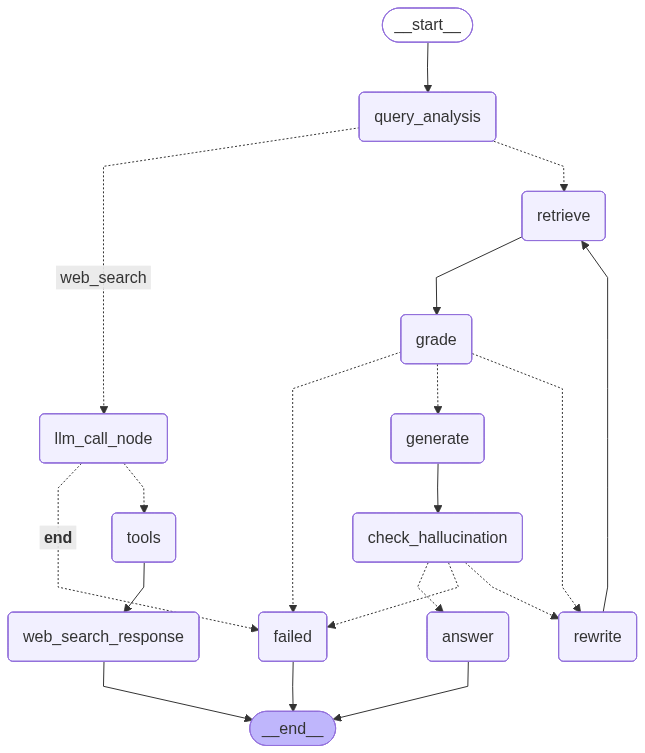

In [60]:
builder: StateGraph = StateGraph(State)

# Add nodes
tool_node = ToolNode([search_tool])

builder.add_node(
    "query_analysis",
    classify_query_node,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "tools", tool_node, retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0)
)
builder.add_node("llm_call_node", llm_call_node)
builder.add_node("retrieve", retrieve_documents)
builder.add_node(
    "grade",
    grade_documents,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "generate",
    generate_response,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "rewrite",
    rewrite_query,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "check_hallucination",
    check_hallucination_node,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "web_search_response",
    generate_web_search_response,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node("answer", answer_node)
builder.add_node("failed", failed_node)


# Build the graph query_analysis
builder.add_edge(START, "query_analysis")
builder.add_conditional_edges(
    "query_analysis",
    should_continue_to_retrieve,
    {"retrieve": "retrieve", "web_search": "llm_call_node"},
)
builder.add_conditional_edges(
    "llm_call_node",
    tools_condition,
    {"tools": "tools", END: "failed"},
)
builder.add_edge("tools", "web_search_response")
builder.add_edge("web_search_response", END)
builder.add_edge("retrieve", "grade")
builder.add_conditional_edges(
    "grade",
    should_continue_to_generate,
    {"generate": "generate", "rewrite": "rewrite", "failed": "failed"},
)
builder.add_edge("generate", "check_hallucination")
builder.add_conditional_edges(
    "check_hallucination",
    should_continue_to_final_answer,
    {"answer": "answer", "rewrite": "rewrite", "failed": "failed"},
)
builder.add_edge("answer", END)
builder.add_edge("rewrite", "retrieve")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [61]:
remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GPT_OSS_20B,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don’t skeletons fight each other? They don’t have the guts.


In [62]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"query": "Any news on Liverpool's player meetings?"},
    config=config,
)

Calling ===> classify_query_node <===
✅ Classified query to use data source: vectorstore
Calling ===> retrieve_documents <===
✅ Retriever choice: ai news
✅ Used AI retriever, found 3 documents
Calling ===> grade_documents <===
✅ Graded documents: 0/3 relevant
Calling ===> rewrite_query <===
Original: Any news on Liverpool's player meetings?
Rewritten: Any recent updates on Liverpool's player meetings?
⚠️ Runs: 1
Calling ===> retrieve_documents <===
✅ Retriever choice: football news
✅ Used football retriever, found 3 documents
Calling ===> grade_documents <===
✅ Graded documents: 1/3 relevant
Calling ===> generate_response <===
Calling ===> check_hallucination_node <===
✅ Hallucination check: no
Calling ===> answer_node <===


In [63]:
response

{'query': "Any news on Liverpool's player meetings?",
 'messages': ['Retrieved 3 documents:\nSource: ../data/ai_news/china_self_reliance.pdf\nContent: committee members were present at the meeting, a rare level of absence\nthat the official readout did not explain.\nRead More: China Military Purge Targets Group Who Undermined Xi’s\nAuthority\n(Updates with more details and comments throughout.)\nSave\nContact us:\nProvide news feedback or report an error\nSite feedback:\nTake our Survey\nConfidential tip?\nglobal news. Cancel\nanytime.\nExplore Offers\xa0 \nGet uninterrupted access to\n l b l C l\nGet unlimited access today. [truncated]\n\n\nSource: ../data/ai_news/nvidia.pdf\nContent: 3 Sep 2025\nHome News Sport Business Innovation Culture Arts Travel Earth Audio Video Live Weather BBC Shop BritBox\nBBC in other languages\n10/23/25, 7:26 PM Nvidia to invest $100bn in OpenAI, ﬁrm behind ChatGPT\nhttps://www.bbc.com/news/articles/c0knp3557j2o 3/3 [truncated]\n\n\nSource: ../data/ai_news

In [64]:
Markdown(f"### Final Response:\n\n{response['response']}")

### Final Response:

Liverpool captain Virgil van Dijk has clarified that the players’ meeting held this week was not a “crisis meeting.” He said the gathering was meant to address recent struggles but was not a sign of panic. The meeting came after Liverpool ended a four‑match losing streak with a 5‑1 victory over Eintracht Frankfurt in the Champions League. No further details about the meeting’s agenda were released.

In [ ]:
# Display all keys in other_info
console.print("\n[cyan]Keys in other_info:[/cyan]", style="info")
for key, value in response.get("other_info", {}).items():
    console.print(f"  • {key}: {value}", style="success")